In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
# import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
import fitsio
# from astropy.io import fits

In [2]:
cat = Table.read('/Users/rongpu/Downloads/OzDES-DR2.fits')
print(len(cat))

38624


In [3]:
cat[:5]

ozdes_id,alpha_j2000,delta_j2000,rmag,object_types,z,qop,transient_type,comment
bytes27,bytes9,bytes10,bytes5,bytes74,bytes8,bytes1,bytes9,bytes51
OzDES-DR2_00001,36.609138,-4.986051,24.4,SNLS,-9.999,1,None,None
OzDES-DR2_00002,36.46225,-4.64347,24.3,SNLS,-9.999,2,None,None
OzDES-DR2_00003,36.114389,-4.799381,22.1,PHOTOZ,-9.999,1,None,None
OzDES-DR2_00004,36.081501,-4.798006,22.38,PHOTOZ,-9.999,1,None,None
OzDES-DR2_00005,36.933318,-4.793021,22.17,PHOTOZ,-9.999,1,None,None


In [4]:
for col in ['alpha_j2000', 'delta_j2000', 'rmag', 'z']:
    cat[col] = cat[col].astype('float')
cat['qop'] = cat['qop'].astype('int')

In [5]:
cat

ozdes_id,alpha_j2000,delta_j2000,rmag,object_types,z,qop,transient_type,comment
bytes27,float64,float64,float64,bytes74,float64,int64,bytes9,bytes51
OzDES-DR2_00001,36.609138,-4.986051,24.4,SNLS,-9.999,1,None,None
OzDES-DR2_00002,36.46225,-4.64347,24.3,SNLS,-9.999,2,None,None
OzDES-DR2_00003,36.114389,-4.799381,22.1,PHOTOZ,-9.999,1,None,None
OzDES-DR2_00004,36.081501,-4.798006,22.38,PHOTOZ,-9.999,1,None,None
OzDES-DR2_00005,36.933318,-4.793021,22.17,PHOTOZ,-9.999,1,None,None
OzDES-DR2_00006,34.739462,-5.199134,19.66,DEVILS,0.22024,4,None,None
OzDES-DR2_00007,35.432856,-5.19879,18.93,DEVILS,0.3228,3,None,None
OzDES-DR2_00008,34.132414,-5.19392,19.41,DEVILS,0.34798,4,None,None
OzDES-DR2_00009,35.2781,-5.194779,19.17,DEVILS,0.35615,4,None,None


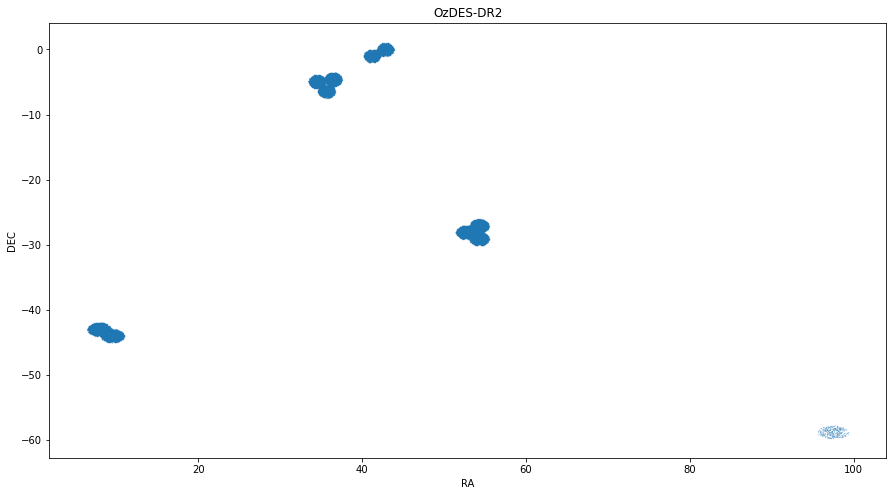

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(cat['alpha_j2000'], cat['delta_j2000'], '.', markersize=0.4, alpha=0.5)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('OzDES-DR2')
plt.show()

__Check for duplicates__

In [7]:
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
import match_coord

1117 objects with a nearby neighbor


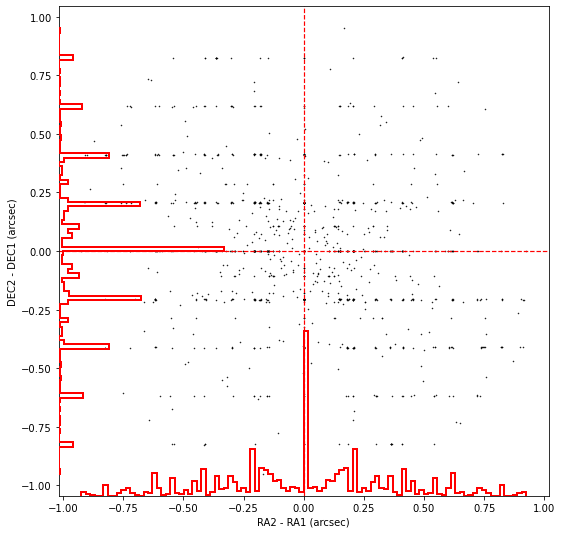

1117 2.89%


In [8]:
n_duplicates, idx1, idx2 = match_coord.match_self(cat['alpha_j2000'], cat['delta_j2000'], search_radius=1., 
                                                  return_indices=True, plot_q=True)
print(n_duplicates, '{:.2f}%'.format(n_duplicates/len(cat)*100))

------------
## Remove duplicates

In [9]:
ra_col = 'alpha_j2000'
dec_col = 'delta_j2000'

quality_col = 'qop'

# perturb the coordinates so that the 2nd closest match won't be itself
np.random.seed(618)
cat['dec_perturb'] = np.array(cat[dec_col], dtype=np.float64) + np.random.rand(len(cat))*(0.001/3600)

# Assign a random number to break the tie
random = np.random.rand(len(cat))

continue_loop = True
loop = 0
while continue_loop:
    
    print('Loop %d'%loop)
    loop = loop+1

    n_duplicates, idx1, idx2 = match_coord.match_self(cat[ra_col], cat['dec_perturb'], search_radius=1., 
                                                      return_indices=True, plot_q=False)
    
    mask = (cat[quality_col][idx1]<cat[quality_col][idx2]) \
                  | ((cat[quality_col][idx1]==cat[quality_col][idx2]) & (random[idx1]<random[idx2]))
    idx_remove = idx1[mask]    
    cat.remove_rows(idx_remove)
    print('{} objects removed'.format(len(idx_remove)))
    
    if n_duplicates==0:
        continue_loop = False

Loop 0
1117 objects with a nearby neighbor
557 objects removed
Loop 1
6 objects with a nearby neighbor
3 objects removed
Loop 2
0 objects with a nearby neighbor
0 objects removed


In [10]:
cat.remove_column('dec_perturb')

In [11]:
print(len(cat))

38064


In [12]:
n_duplicates, idx1, idx2 = match_coord.match_self(cat['alpha_j2000'], cat['delta_j2000'], search_radius=1., 
                                                  return_indices=True, plot_q=True)
print(n_duplicates, '{:.2f}%'.format(n_duplicates/len(cat)*100))

0 objects with a nearby neighbor
0 0.00%
